## Выявление спама
 - Считайте датасет (SMSSpamCollection.txt) в Python , выясните, что используется в качестве разделителей и как проставляются метки классов.

 - Подготовьте для дальнейшей работы два списка: список текстов в порядке их следования в датасете и список соответствующих им меток классов. В качестве метки класса используйте 1 для спама и 0 для "не спама".
 
 - Используя средства работы с текстами - обучите систему идентификации спама
 - визуализируйте результат работы логистической регрессии. Какие признаки наиболее важны для детекции спама?
 - Постройте пайплайн для выбора моделей и параметров, используйте   LogisticRegression, SVС, MultinomialNB (эта модель может работать только с признаками счетчиками, то есть tfidf туда не стоит отправлять)
 

In [68]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter("ignore")
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier,LogisticRegressionCV
from sklearn.svm import LinearSVC
from  sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.feature_extraction.text import CountVectorizer

In [12]:
#!pip install nltk

In [14]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/datalore/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/datalore/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/datalore/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
data = pd.read_csv('SMSSpamCollection.txt', sep='^(\S+)', names=['target', 'text'], engine='python', usecols=[1, 2])

In [10]:
data.head()

,target,text
0,ham,"\tGo until jurong point, crazy.. Available onl..."
1,ham,\tOk lar... Joking wif u oni...
2,spam,\tFree entry in 2 a wkly comp to win FA Cup fi...
3,ham,\tU dun say so early hor... U c already then s...
4,ham,"\tNah I don't think he goes to usf, he lives a..."


In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   target    5574 non-null   object
 1   text      5574 non-null   object
 2   target_b  5574 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 130.8+ KB


## Описание данных 

У нас есть датасет с двумя колонками - первая наш таргет, который в следующем шаге мы преобразуем в числовую бинарную форму, где спам - это 1, а не спам - 0. Всего у нас 5574 сообщения. 

In [27]:
data.loc[data['target'] == 'ham', 'target_b'] = 0
data.loc[data['target'] == 'spam', 'target_b'] = 1
data.target_b = data.target_b.astype('int')

In [36]:
data.shape

(5574, 3)

Создадим два списка: в **label** будет хранится информация о таргете, а в **new_text** соответственно текст сообщений

In [33]:
label = data.target_b.to_list()
text = data.text.to_list()
new_text = []
for string in text:
    string = string.replace('\t',"")
    new_text.append(string)

In [40]:
new_text[:5]

['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
 'Ok lar... Joking wif u oni...',
 "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
 'U dun say so early hor... U c already then say...',
 "Nah I don't think he goes to usf, he lives around here though"]

In [39]:
print(f'Размер списка с текстами: {len(new_text)}')
print(f'Размер списка с лейблами: {len(label)}')

Размер списка с текстами: 5574
Размер списка с лейблами: 5574


In [44]:
print(f'В нашей выборке спама: {label.count(1)}')
print(f'В нашей выборке не спама: {label.count(0)}')

В нашей выборке спама: 747
В нашей выборке не спама: 4827


Так как у нас несбалансировання выборка, при делении на тестовую и валидационную подвыборки укажем аргумент stratify=label.

In [45]:
text_train, text_val, y_train, y_val = train_test_split(new_text, label,  random_state=1234, shuffle=True, stratify=label)

In [80]:
vect = CountVectorizer(stop_words='english', token_pattern=r"\b\w[\w’]+\b")
X_train = vect.fit_transform(text_train)
X_val = vect.transform(text_val)
X_train

<4180x7197 sparse matrix of type '<class 'numpy.int64'>'
	with 32467 stored elements in Compressed Sparse Row format>

In [81]:
print(f'Обучим логистическую регрессию:\n')
lr = LogisticRegression().fit(X_train, y_train)
print(f"Качество на обучении {lr.score(X_train, y_train)}: и на валидации: {lr.score(X_val, y_val)}")

Обучим логистическую регрессию:

Качество на обучении 0.9954545454545455: и на валидации: 0.9799139167862266


              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1207
           1       0.99      0.86      0.92       187

    accuracy                           0.98      1394
   macro avg       0.99      0.93      0.95      1394
weighted avg       0.98      0.98      0.98      1394

[[1206    1]
 [  27  160]]


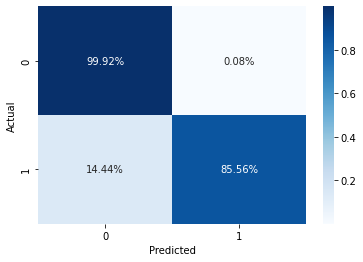

In [82]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

# считаем метрики
print(classification_report(y_val, lr.predict(X_val)))

# нарисуем матрицу ошибок
cm = confusion_matrix(y_val, lr.predict(X_val))
#нормализуем так, чтобы у нас выводились значения в процентах от целевого значения
df_cm = pd.DataFrame(cm/cm.sum(axis=1)[:, np.newaxis].round(2), columns=[0,1], index = [0,1])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
print(cm)
sns.heatmap(df_cm, annot=True, fmt='.2%', cmap='Blues')
plt.show()

В целом показатели логистической регресси достаточно хорошие. Наша модель достаточно хорошо понимает, где не спам, но вот с опеределением нашей целевой метрики можно поработать, 15 процентов спама на валидационной выборке осталось не замеченым. 

In [63]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right")

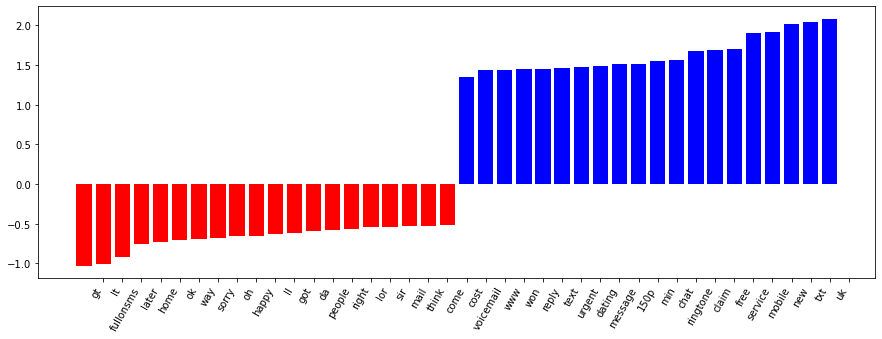

In [85]:
visualize_coefficients(lr, vect.get_feature_names(), n_top_features=20)

Мы видим, что некоторые слова делают достаточно сильный вклад в выявлении спама, например, "won", "urgent" и так далее. Вычленяя отдельные слова сложно сказать, почему именно они относятся к спаму, хотя если прочитать слова с положительным вкладом - складывается какое-то общее впечатление)  

Со словами с отрицательным вкладом сложнее, они не несут такую сильную нагрузку, как слова помогающее выявлять спам. Можно сказать, что мы скорее отличаем спам от не спама по принципу: если там нет слов из спама, то скорее всего не спам - а не наоборот.

## Pipeline

In [75]:
def text_classifier(vectorizer, classifier):
    pipe =  Pipeline(
            [("vectorizer", vectorizer),
            ("classifier", classifier)])
    return pipe     
        

In [66]:
from nltk.stem import WordNetLemmatizer

In [83]:
for clf in [LogisticRegression, LinearSVC, MultinomialNB]:
    print(clf)
    print(cross_val_score(text_classifier(CountVectorizer(stop_words='english', min_df = 4, 
                                                            token_pattern=r"\b\w[\w’]+\b"), clf()),text_train,y_train).mean())

<class 'sklearn.linear_model._logistic.LogisticRegression'>
0.9782296650717702
<class 'sklearn.svm._classes.LinearSVC'>
0.9808612440191388
<class 'sklearn.naive_bayes.MultinomialNB'>
0.9815789473684211
